# PySCNet: A tool for reconstructing and analyzing gene regulatory network from single-cell RNA-Seq data

PySCNet includes four modules:

1) **Pro-precessing**: initialize a gnetData object consisting of Expression Matrix, Cell Attributes, Gene Attributes and Network Attributes; <br/>
2) **BuildNet**: reconstruct GRNs by various methods implemented in docker;<br/>
3) **NetEnrich**: network analysis including consensus network detection, gene module identification and trigger path prediction;<br/>
4) **Visulization**: network illustration.<br/>

A python package - [STREAM](https://github.com/pinellolab/STREAM) was designed for reconstructing cell trajectory for single cell transcriptomic data. This tutorial guides how to integrate STREAM with pyscnet for gene regulatory network along the cell differential trajectory.


In [1]:
from __future__ import absolute_import
import warnings
warnings.filterwarnings("ignore")

import sys
import os
import itertools
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

from pyvis.network import Network
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt 

from pyscnet import Preprocessing as pp
from pyscnet import BuildNet as bn
from pyscnet import NetEnrich as ne
from pyscnet import Plotting as pl
pd.set_option('display.max_rows', 1000)

scanpy==1.5.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.4 scipy==1.5.2 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.7.0 leidenalg==0.8.2


### Data resource
Data was obtained from [Nestorowa, S. et al](https://doi.org/10.1182/blood-2016-05-716480). The cell trajectory was build according to [STREAM Tutorial](https://nbviewer.jupyter.org/github/pinellolab/STREAM/blob/master/tutorial/1.1.STREAM_scRNA-seq%20%28Bifurcation%29.ipynb?flush_cache=true). As STREAM is also built on AnnData structure, it can be directly imported into pyscnet.

In [2]:
#the file is too large
# import _pickle as pk
# with open('data/stream_adata.pk', 'rb') as input:
#     adata = pk.load(input)
#user jupyter-notebook in stream env: ~/miniconda3/envs/stream/bin/
import stream as st
adata = st.read('tutorial_data/pyscnet_stream_hsc/stream_adata.pklz')


Working directory is already specified as './result' 
To change working directory, please run set_workdir(adata,workdir=new_directory)


As explained in [STREAM Tutorial](https://nbviewer.jupyter.org/github/pinellolab/STREAM/blob/master/tutorial/1.1.STREAM_scRNA-seq%20%28Bifurcation%29.ipynb?flush_cache=true), new attributes including cell pseudotime at different branches are added into **obs** of AnnData. It gives us the hints of ordering cells and investigating gene dynamics along the cell trajectory.

### Cell trajectories built by stream
As shown below, Cells were divided into six sub-groups and were formed into two distinct cell lines. Hematopoietic stem cells (HSCs) expanded towards: 1) megakaryocyte-erythrocyte progenitors (MEPs); 2) the mixture of lymphoid-primed multipotent progenitors (LPMPs) and granulocyte-monocyte progenitors (GMPs). Additionally, leaf markers and transition markers are detected for each branch.

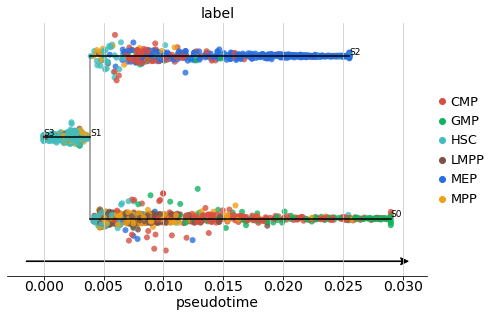

In [3]:
st.plot_stream_sc(adata,root='S3',color=['label'],
                  dist_scale=0.1,show_graph=True,show_text=True)
#                   save_fig=True, fig_path='result/cell_branches')

In [4]:
#leaf_markers of cell pathway: S1 -> S2
adata.uns['leaf_markers'][('S1','S2')].head(10)

,zscore,H_statistic,H_pvalue,S3S1_pvalue,S1S2_pvalue,S1S0_pvalue
Mfsd2b,1.41257,938.321,1.76265e-204,2.78863e-209,1,5.62722e-271
Lcp1,-1.41168,838.086,1.02799e-182,1.04374e-144,1,7.64013e-242
Aqp1,1.41421,830.173,5.37295e-181,7.15629e-161,1,5.32332e-230
Gata1,1.41361,829.465,7.65578e-181,1.96117e-162,1,9.52239e-229
Klf1,1.41378,801.407,9.47857e-175,2.91898e-158,1,5.26742e-215
Prtn3,-1.36735,777.029,1.86338e-169,1.77339e-84,1,3.29993e-228
Coro1a,-1.40811,741.758,8.49768e-162,6.00919e-100,1,6.86245e-210
Blvrb,1.40957,739.366,2.81053e-161,3.34062e-116,1,1.84013e-203
Lsp1,-1.40424,734.943,2.56514e-160,6.12016e-153,1,1.45316e-180
Gm15915,1.41395,724.83,4.02806e-158,9.5433e-137,1,4.08843e-186


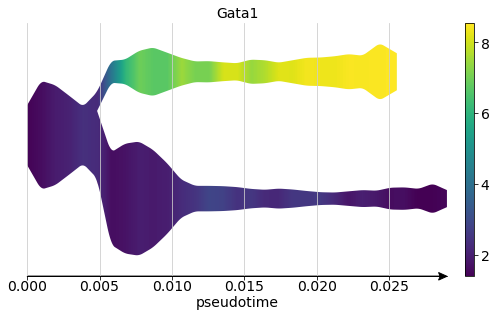

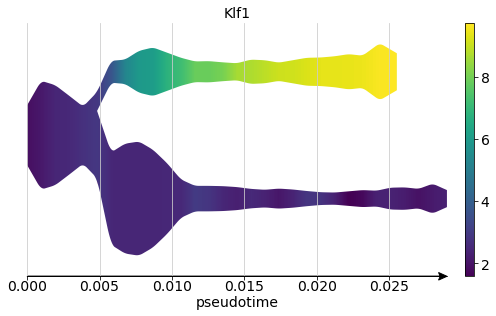

In [5]:
st.plot_stream(adata,root='S3',color=['Gata1','Klf1'])

In [6]:
#Import stream anndata into pyscnet
stream_gne = pp.load_from_anndata(adata)

### Select trajectory branch and Features for GRN:
In the following, cells from **S1** to **S2** and **positive leaf markers** of (S1->S2) will be selected for GRN construction. As shown below, positive leaf markers are only highly expressed in cells of S1 -> S2. There are 236 genes and 535 cells selected for downstream analysis. 


<!-- As reported in [this publication](https://www.pnas.org/content/114/23/5822), GRNs specific for **MEP (S1->S2)** and **LMPP(S1->S3)** were built based on pre-selected 31 features. In the following, cells from above branches will be individually tested for gene correlation.  -->
<!-- Features_Paper = ['Bptf', 'Cbfa2t3', 'Erg', 'Ets1', 'Ets2', 'Etv6', 'Fli1', 'Gata1', 'Gata2', 'Gata3', 'Gfi1b', 'Hhex',
           'Hoxa5', 'Hoxa9', 'Hoxb4', 'Ikzf1', 'Ldb1', 'Lmo2', 'Lyl1', 'Meis1', 'Mitf', 'Myb', 'Nfe2', 'Nkx2-3',
           'Notch1', 'Pbx1', 'Prdm16', 'Runx1', 'Smarcc1', 'Tal1', 'Tcf7']

# list(filter(lambda x:'Not' in x, stream_gne.ExpMatrix.index))
# [gene in stream_gne.ExpMatrix.index for gene in Features_Paper] -->

In [7]:
#select cells from S1 -> S2
cell_info = stream_gne.CellAttrs['CellInfo'].sort_values('S1_pseudotime', ascending=True)
cell = list(cell_info.loc[cell_info['branch_id_alias'].isin([('S2', 'S1')])].index)
len(cell)

#select positive leaf markers 
feature = adata.uns['leaf_markers'][('S1', 'S2')]
# feature = feature.sort_values('zscore', ascending=False).head(100).index
feature = feature[feature.zscore > 0].index

len(feature)

236

<!-- ### Optional: 
As reported in this publication, GRNs specific for MEP (S1->S2) and LMPP(S1->S3) were built based on pre-selected 31 features. In the following, cells from above branches will be individually tested for gene correlation.  -->

<!-- feature = ['Bptf', 'Cbfa2t3', 'Erg', 'Ets1', 'Ets2', 'Etv6', 'Fli1', 'Gata1', 'Gata2', 'Gata3', 'Gfi1b', 'Hhex',
           'Hoxa5', 'Hoxa9', 'Hoxb4', 'Ikzf1', 'Ldb1', 'Lmo2', 'Lyl1', 'Meis1', 'Mitf', 'Myb', 'Nfe2', 'Nkx2-3',
           'Notch1', 'Pbx1', 'Prdm16', 'Runx1', 'Smarcc1', 'Tal1', 'Tcf7']
 -->

### Remove isolated nodes:
In order to evaluate the performance of different GRN methods, reference linkage was download from [string PPI](https://string-db.org/) filtered by **high confidence score > 0.7** and **PPI enrichment p-value < 1.0e-16**. There are 420 edges built from 117 features. Other 119 isolated ndoes were removed for GRN construction.

In [8]:
import networkx as nx
#leaf markers
Ref_edges = pd.read_csv('tutorial_data/pyscnet_stream_hsc/string_interactions.tsv', 
                          sep='\t').iloc[:,:2]
Ref_edges.columns = ['source', 'target']
Ref_edges['weight'] = 1

G = nx.from_pandas_edgelist(Ref_edges)
feature = list(set(feature) & set(G.nodes))

len(feature)


117

<!-- # Set window size to compute moving window synchrony.
r_window_size = 50
subExpr = stream_gne.ExpMatrix.loc[feature, cell]
df = subExpr.T
genes = ['Gata1', 'Klf1']
# Interpolate missing data.
df_interpolated = df.interpolate()
# Compute rolling window synchrony
rolling_r = df_interpolated[genes[0]].rolling(window=r_window_size, center=True).corr(df_interpolated[genes[1]])
f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)

df[genes].rolling(window=r_window_size,center=True).mean().plot(ax=ax[0])
ax[0].set(xlabel='Frame',ylabel='Expression level')
rolling_r.plot(ax=ax[1])
ax[1].set(xlabel='Frame',ylabel='Pearson r')
plt.suptitle("pairwise gene and rolling window correlation")

f.savefig('result/gene_dynamics.pdf') -->

### BuildNet: Construct GRN by applying popular methods 
As reported in [GRN benchmark paper](https://pubmed.ncbi.nlm.nih.gov/31907445/), three methods ([GENIE3](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0012776), [PIDC](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5624513/) and [GRNBOOST2](https://academic.oup.com/bioinformatics/article-abstract/35/12/2159/5184284?redirectedFrom=fulltext)) were considered as competitive. Moreover, two additional methods (**window_rolling** and **phase synchrony**) are also provided in the pyscnet. 



<!-- Mms = pd.read_csv('../Mus_TF_and_TFcofactor/Mus_musculus_TF.txt', sep='\t')
Tfs = list(set(Mms.Symbol) & set(feature))
Tfs -->

In [9]:
methods_list = ['GENIE3', 'GRNBOOST2', 'CORR', 'window_rolling', 'phase_synchrony']

for method in methods_list:
    if method in ['window_rolling', 'phase_synchrony']:
        stream_gne = bn.get_synchrony(stream_gne.deepcopy, method=method,
                                      feature=feature, cell=cell)
    else:
        stream_gne = bn.rundocker(stream_gne.deepcopy, method=method,
                                      feature=feature, cell=cell, directed=False)

GENIE3_links added into NetAttrs
GRNBOOST2_links added into NetAttrs
CORR_links added into NetAttrs
window_rolling_links added into NetAttrs
phase_synchrony_links added into NetAttrs


<!-- ### NetEnrich: Consensus edges and Build graph
pyscnet provides multiple ways of predicting consensus network: 

1) random forest classification; <br/>
2) network intersection; <br/>

Given consensus prediction, top *k* edges are selected for building gene graph. Genes importance can be estimated via node centralities including **Degree, PageRank, Closeness**. Furthermore, gene modules are predicted by applying community detection algorithms.

#find consensus links based on ensemble classification
stream_gne = gt.find_consensus_graph(stream_gne, method='intersection', toprank=5000, threshold=1)

#build graph for consensus links
stream_gne = gt.buildnet(stream_gne, key_links='consensus') -->

<!-- ### Assess confidence of censensus network
Here we applied ensemble classification to train the edges with average weight greater than 1.5. It gives us 130 consensus edges. To quality the confidence of obtained edges, we take the network (112 edges) from the paper as a reference and evaluate the confidence of consensus network. To do so, we select top 112 edges from four GRN methods and consensus edges to calculate ROC and PRC. -->

### Assess confidence of different GRNs
To quality the confidence of GRNs obtained from differen methods, top 420 edges were selected from each methods. ROC and PR curves were ultilized for methods evaluation.

In [10]:
#remove self-loop edges
index_list=list()
for i in range(Ref_edges.shape[0]):
    if Ref_edges.iloc[i]['source'] == Ref_edges.iloc[i]['target']:
        index_list.append(i)
Ref_edges=Ref_edges.drop(index_list)

#As edges are undirected, the following is to create Full reference links (117*116/2) and then merge with the string links 
from itertools import product, permutations, combinations, combinations_with_replacement
Full_Ref = pd.DataFrame(combinations(set(feature), 2), columns=['source', 'target'])
Full_Ref['weight'] = 0

Ref_edges['name']= ["_".join(sorted([Ref_edges.source[i], Ref_edges.target[i]])) for i in range(Ref_edges.shape[0])]
Full_Ref['name']= ["_".join(sorted([Full_Ref.source[i], Full_Ref.target[i]])) for i in range(Full_Ref.shape[0])]

Full_Ref.loc[Full_Ref.name.isin(list(set(Full_Ref['name']) & set(Ref_edges['name']))), 'weight'] = 1

Full_Ref[Full_Ref.weight == 1].shape



(420, 4)

<!-- #extend reference links by shortest paths
# import networkx as nx
# Tmp = Full_Ref[Full_Ref.weight == 1]
# G = nx.from_pandas_edgelist(Tmp)
# path_len = list()
# for i in range(Full_Ref.shape[0]):
#     if Full_Ref.iloc[i]['source'] in G.nodes and Full_Ref.iloc[i]['target'] in G.nodes:
#         if nx.has_path(G, Full_Ref.iloc[i]['source'], Full_Ref.iloc[i]['target']):
#             path_len.append(nx.shortest_path_length(G, Full_Ref.iloc[i]['source'], Full_Ref.iloc[i]['target']))
#         else:
#             path_len.append(0)
#     else:
#         path_len.append(0)
    

# Full_Ref['path_len'] = path_len
# Full_Ref['weight'] = [1 if x in [1] else 0 for x in Full_Ref.path_len]
# Full_Ref[Full_Ref.weight == 1].shape -->

### Phase synchrony based method outperforms others
As shown below, phase synchrony method outperforms others in terms of top 420 edges. 

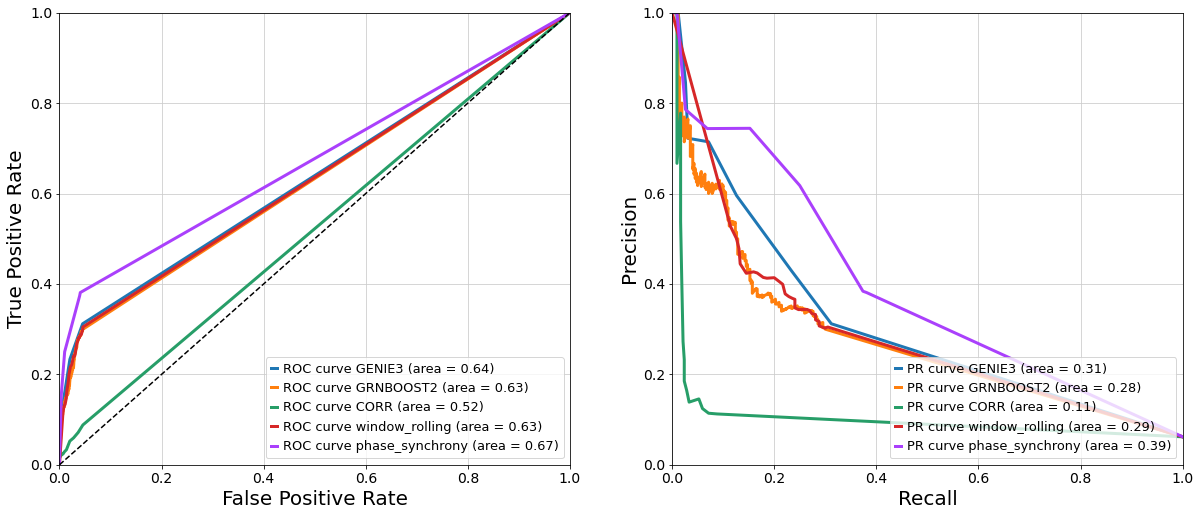

In [11]:
import alg_evaluation

dict_of_algs = dict()
link_keys = list(filter(lambda x:'_links' in x, stream_gne.NetAttrs.keys()))

for link in link_keys:
    method = link.split('_links')[0]
    top = stream_gne.NetAttrs[link].sort_values('weight', ascending=False).head(420).reset_index(drop=True)
    dict_of_algs[method] = alg_evaluation.evaluation(top, copy.deepcopy(Full_Ref))

    
fig = plt.figure(figsize=(20, 8))
grid = plt.GridSpec(1, 2, wspace=0.2, hspace=0.2)

ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[0, 1])
    
filename='test'
alg_evaluation.build_curves(ax1, dict_of_algs, 'ROC', filename, linewidth=3)
alg_evaluation.build_curves(ax2, dict_of_algs, 'PCR', filename, linewidth=3)


# fig.savefig('result/test_consensus_confidence.pdf')

### NetEnrich: Graph travel and supervised random walk
NetEnrich module integrates graph traversal techniques to expolre gene regulatory network. It includes **Breadth-first search**, **Depth-first search** and **Supervised random walk**. In this way, gene trigger paths indicating genes with hidden associations can be predicted. 

In [12]:
#build graph
stream_gne = ne.buildnet(stream_gne, key_links='phase_synchrony_links', top=420)

#calculate node centrality
stream_gne = ne.get_centrality(stream_gne)

#detect gene community
stream_gne = ne.detect_community(stream_gne)


graph added into NetAttrs
node centralities added into NetAttrs.
gene communities added into NetAttrs


### Missing regulation links can be detected by supervised random walk

We take node **Mki67** as a starting point and perform a 5-steps random walk guided by node centrality (**i.e. degree**). Superisely, three co-regulation edges (**Mki67-Rrm2, Mki67-Mcm5, Mki67-Mcm7**) failed to be predicted but surprisingly found in the 5 steps of greedy walk.

In [23]:
# greedy walk
node = 'Mki67'
random_path = ne.self_guide_walk(stream_gne, start = node, method = 'greedy_walk', supervisedby='degree', steps=5)
random_path

['Mki67', 'Rrm1', 'Mcm2', 'Mcm3', 'Mcm7', 'Mcm5']

Text(0.5, 1.0, 'Edges connected to Mki67 in prediction')

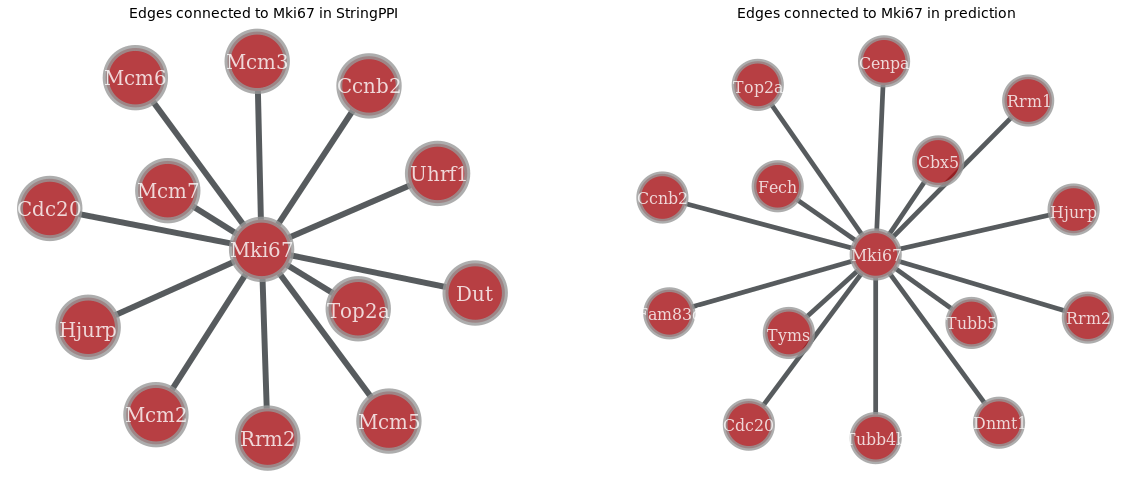

In [14]:
import graph_tool.all as gta
import matplotlib.pyplot as plt
from pyscnet.Plotting import _nx2gt as nx2gt

#select top 420 edges
tmp = stream_gne.NetAttrs['phase_synchrony_links'].sort_values('weight', ascending=False).head(420)
net1 = Ref_edges.loc[(Ref_edges.target== node) | (Ref_edges.source == node)]
net2 = tmp.loc[(tmp.source==node) | (tmp.target==node)]
net3 = tmp.loc[(tmp.source.isin([node])) | (tmp.target.isin(random_path))]


plt.switch_backend("cairo")

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

G1 = nx2gt.nx2gt(nx.from_pandas_edgelist(net1, edge_attr='weight'))
pos = gta.fruchterman_reingold_layout(G1)

edge_color = G1.new_edge_property("string")
labels = dict(zip(list(range(G1.num_vertices())), list(G1.vertex_properties['id'])))

gta.graph_draw(G1, vertex_text=G1.vertex_properties['id'], vertex_text_position=-2,
               vertex_size=0.6,  vertex_font_size=0.2, mplfig=ax[0])

ax[0].set_title('Edges connected to Mki67 in StringPPI')

G1 = nx2gt.nx2gt(nx.from_pandas_edgelist(net2, edge_attr='weight'))
pos = gta.fruchterman_reingold_layout(G1)

edge_color = G1.new_edge_property("string")
labels = dict(zip(list(range(G1.num_vertices())), list(G1.vertex_properties['id'])))

gta.graph_draw(G1, vertex_text=G1.vertex_properties['id'], vertex_text_position=-2,
               vertex_size=0.6,  vertex_font_size=0.2, mplfig=ax[1])

ax[0].axis('off')
ax[1].axis('off')
ax[1].set_title('Edges connected to Mki67 in prediction')


Text(0.5, 1.0, '5 steps random walk starting from Mki67')

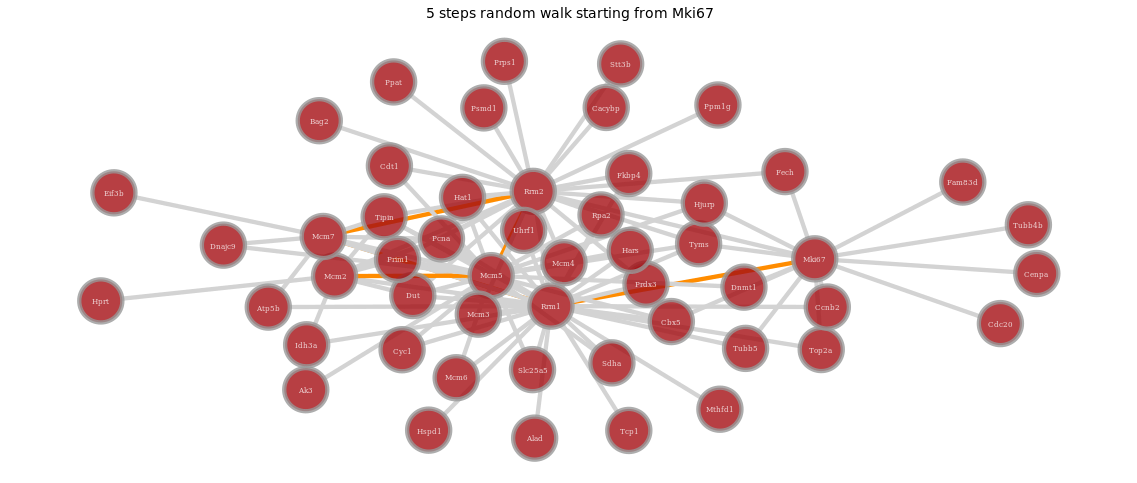

In [15]:
fig, ax = plt.subplots(1, figsize=(20, 8))
G1 = nx2gt.nx2gt(nx.from_pandas_edgelist(net3, edge_attr='weight'))
pos = gta.fruchterman_reingold_layout(G1)

edge_color = G1.new_edge_property("string")
labels = dict(zip(list(range(G1.num_vertices())), list(G1.vertex_properties['id'])))
highlight_path=random_path
for e in G1.edges():
    if (highlight_path is not None) and (labels[list(e)[0]] in highlight_path) and (
            labels[list(e)[1]] in highlight_path) and abs(highlight_path.index(labels[list(e)[0]]) - highlight_path.index(labels[list(e)[1]])) == 1:
        edge_color[e] = 'darkorange'
    else:
        edge_color[e] = 'lightgrey'

pos = gta.arf_layout(G1)
gta.graph_draw(G1, vertex_text=G1.vertex_properties['id'], vertex_text_position=-2,
               edge_color=edge_color, vertex_size=1.2,  vertex_font_size=0.2, mplfig=ax)

ax.axis('off')
ax.set_title('5 steps random walk starting from Mki67')

### Plotting: Network Visualization 
Illustrate network as circle/matrix layout

(-0.9, 9.9, 9.9, -0.9)

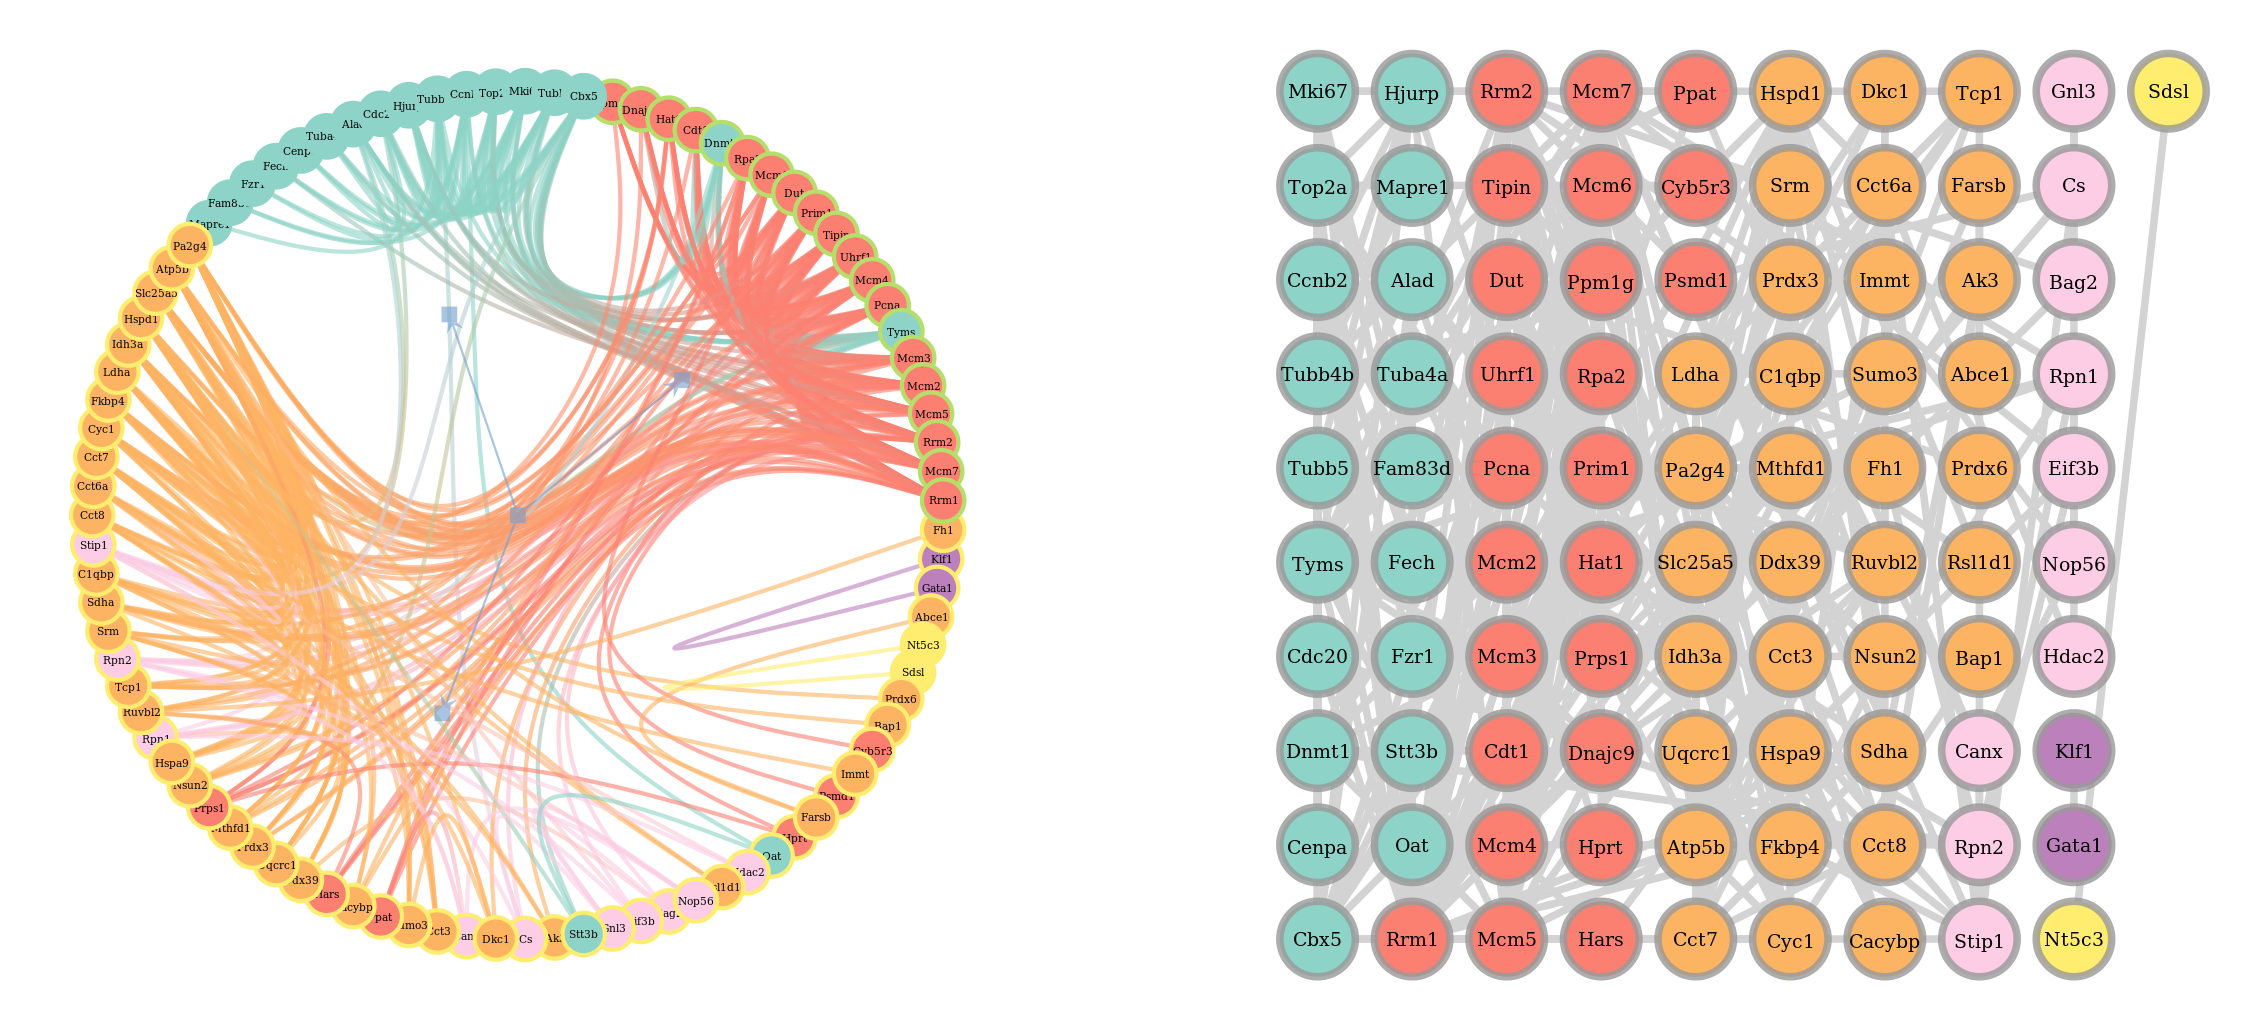

In [16]:
from pyscnet.Plotting import net_plot as npl

plt.switch_backend("cairo")
fig, ax = plt.subplots(1, 2, figsize=(40, 18))
# npl.net_matrix_plot(stream_gne, output_size=(500, 500), vertex_text_position=-2, vertex_font_size=5)
pl.net_hierarchy_plot(stream_gne, vertex_text_position=-2, vertex_size=0.2,  vertex_font_size=0.05, mplfig=ax[0])
pl.net_matrix_plot(stream_gne, vertex_text_position=-2, vertex_size=0.8,  vertex_font_size=0.2, mplfig=ax[1])
ax[0].axis('off')
ax[1].axis('off')
# fig.savefig('result/net_plots.pdf')

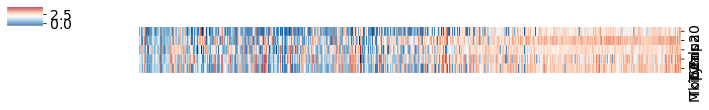

In [17]:
# gene expression heatmap
corr_gene = ['Cdc20', 'Cenpa', 'Tyms', 'Top2a', 'Mki67']
cg = pl.geneHeatmap(stream_gne, gene=corr_gene, figsize=[10,1.5], 
                    cell_clusterid=('S2', 'S1'), select_by='branch_id_alias', yticklabels=True,
                    order_by='S1_pseudotime', col_cluster=False, cmap='RdBu_r')

cg.ax_row_dendrogram.set_visible(False)


<AxesSubplot:>

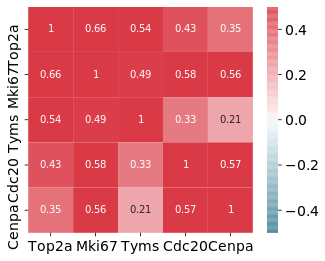

In [18]:
# gene correlation heatmap
corr_gene = ['Top2a', 'Mki67', 'Tyms', 'Cdc20', 'Cenpa']
pl.geneCorrelation(stream_gne, gene=corr_gene,
                cell_clusterid=('S2', 'S1'), select_by='branch_id_alias',
                order_by='S1_pseudotime', xticklabels=True, yticklabels=True,
                figsize=[5, 4], vmax=0.5, vmin=-0.5, annot=True)

Create plotly-dash network in jupyter notebook. Top 200 interactions obtained from phase_synchrony method were seleced for GRN construction. Nodes were colored by gene modules.

In [19]:
new_app = pl.create_app(gnetdata=stream_gne, grn_method='phase_synchrony_links', top_links=200, resolution=0.6)
# new_app

graph added into NetAttrs
node centralities added into NetAttrs.
gene communities added into NetAttrs


In [20]:
#create network in a html format
pl.dynamic_netShow(stream_gne, filename='network_dynamics.html')

In [21]:
#save stream_gne as pickle 
#stream_gne.save_as('pyscnet_stream.pk')


<!-- # assess random and greedy walk
path = ne.random_walk(stream_gne, start='Mki67', steps=5, supervisedby='degree')
def evaluate(G, path):
    count = 0
    for node in path[1:]:
        if node in list(nx.neighbors(G, path[0])):
            count += 1
    return count

random_G = []
for node in list(stream_gne.NetAttrs['graph'].node):
    G_list = []
    for step in [5, 10, 15, 20, 25]:
        G_list.append(evaluate(G, supervised_random_walk(stream_gne, start=node, steps=step, supervisedby='degree', repeat=100)))
    random_G.append(G_list)
random_G = pd.DataFrame.from_records(random_G)       
random_G.index = list(stream_gne.NetAttrs['graph'].node) -->